<a href="https://colab.research.google.com/github/kopalgarg/kaggle-competitions/blob/main/boston-housing-CAPTUM/gradient_based_explainability_CAPTUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import torchviz
from torchviz import make_dot
import captum
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients, \
IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

Import dataset

In [11]:
boston = load_boston()
x = boston.data
y = boston.target

In [14]:
print(x.shape)
print(y.shape)

(506, 13)
(506,)


Split test-train 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2, random_state = 0)

Create batches of data

In [20]:
x_train = torch.tensor(x_train).float()
y_train  = torch.tensor(y_train).view(-1,1).float()
x_test = torch.tensor(x_test).float()
y_test  = torch.tensor(y_test).view(-1,1).float()

datasets = torch.utils.data.TensorDataset(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [22]:
train_iter = torch.utils.data.DataLoader(datasets,
                                         batch_size = 10,
                                         shuffle = True)

In [63]:
batch_size = 50
num_epochs = 200
learning_rate = 0.001
size_h1 = 100
size_h2 = 50
size_h3 = 10
size_h4 = 1

NN model

In [64]:
class BostonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(13, size_h1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_h1, size_h2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_h2, size_h3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_h3, size_h4)
    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [65]:
model = BostonModel()
model.train()

BostonModel(
  (lin1): Linear(in_features=13, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

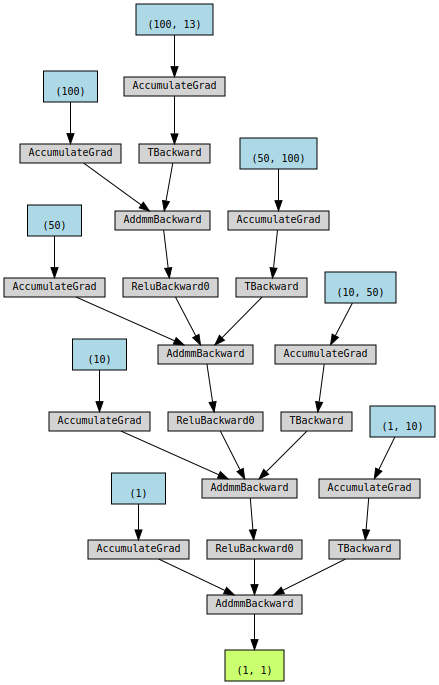

In [66]:
dummy_in = torch.zeros([1,13])
dummy_out = model(dummy_in)
make_dot(dummy_out)

Train model

In [67]:
loss_function = nn.MSELoss(reduction = 'sum')

def train(model, num_epochs = num_epochs):
  optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
  for epoch in range(num_epochs):
    run_loss  = 0
    for inputs, labels in train_iter:
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      run_loss+=loss.item()
      optimizer.step()
    if epoch %20 == 0:
      print(f'Epoch {epoch+1}/{num_epochs} running accumulative loss {run_loss:.3f}')



In [68]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        print("Loading pretrain model  from {}".format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:
        train(model_obj)
        print('Finished training the model. Sasving teh model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [70]:
save_path = 'boston_model_2.pt'
train_load_save_model(model, save_path)

Epoch 1/200 running accumulative loss 10177.156
Epoch 21/200 running accumulative loss 3805.950
Epoch 41/200 running accumulative loss 3998.399
Epoch 61/200 running accumulative loss 3788.282
Epoch 81/200 running accumulative loss 3915.924
Epoch 101/200 running accumulative loss 3303.283
Epoch 121/200 running accumulative loss 2944.127
Epoch 141/200 running accumulative loss 3544.652
Epoch 161/200 running accumulative loss 2687.107
Epoch 181/200 running accumulative loss 2710.443
Finished training the model. Sasving teh model to the path: boston_model_2.pt


Evaluate model

In [71]:
model.eval()
outputs = model(x_test)
pred = outputs.detach().numpy()
true = y_test.detach().numpy()

In [74]:
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))
err

5.849765

Different attribution methods in the Captum library

Gradient SHAP

In [75]:
ig = IntegratedGradients(model)
ig_atest = ig.attribute(x_test, n_steps =50)


Noise Tunnel

In [78]:
nt = NoiseTunnel(ig)
nt_atest = nt.attribute(x_test)

Deep Lift

In [80]:
dl = DeepLift(model)
dl_atest = dl.attribute(x_test)

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


Gradient SHAP

In [81]:
gs = GradientShap(model)
gs_atest = gs.attribute(x_test, x_train)

Feature ablation

In [82]:
fa = FeatureAblation(model)
fa_atest = fa.attribute(x_test)

Comparison

In [92]:
x_axis_data = np.arange(x_test.shape[1])
x_axis_data_labels = list(map(lambda idx: boston.feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_atest.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = nt_atest.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_atest.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_atest.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_atest.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight.detach().numpy().sum(0)
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

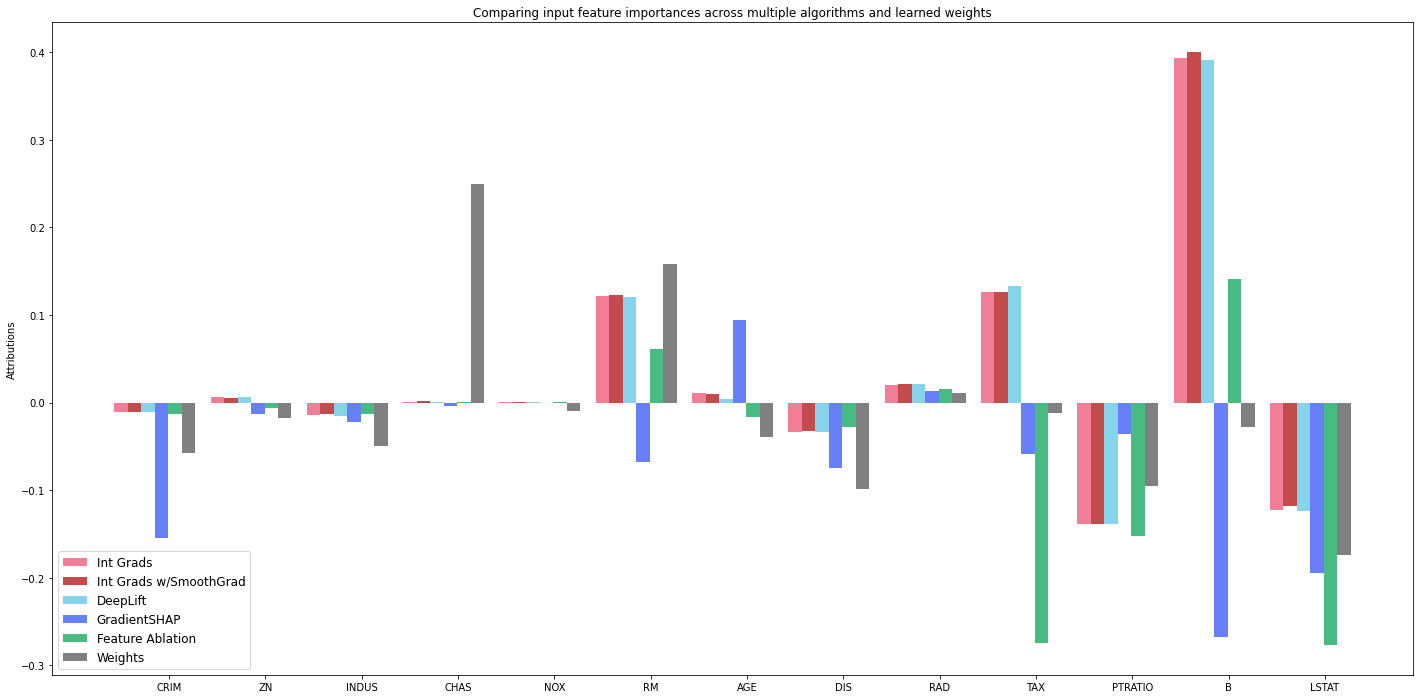

In [93]:
width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()